In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pytensor

import hssm
import ssms.basic_simulators

pytensor.config.floatX = "float32"

### Using include paramater to use regression and update priors.

#### Case 1: Regression type formula. 

In [2]:
# get some fake simulation data
intercept = 0.3
x = np.random.uniform(0.2, 0.5, size=1000)
y = np.random.uniform(0.1, 0.4, size=1000)

v = intercept + 0.8 * x + 0.3 * y

In [3]:
true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)
true_values.shape

(1000, 5)

In [4]:
obs_ddm_reg_v = ssms.basic_simulators.simulator(true_values, model="ddm", n_samples=1)
obs_ddm_reg_v

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,0.754000,1,0.399522,0.191124
1,2.371031,-1,0.213659,0.196646
2,4.222913,1,0.327243,0.315660
3,1.967013,1,0.313571,0.223527
4,1.889009,1,0.311846,0.180569
...,...,...,...,...
995,1.293993,-1,0.451769,0.152684
996,7.041708,1,0.294270,0.393889
997,3.004001,-1,0.227214,0.338196
998,2.252026,-1,0.284006,0.112674


- v is parent
- x is a feature from the dataset_reg_v
- y is a feature from the dataset_reg_v

In [5]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.0, "upper": 0.5},
                "x": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": 0.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Observations: 1000

Parameters:

v ~ 1 + x + y
	Link: identity
	bounds: (-3.0, 3.0)
	Intercept ~ Uniform(lower: 0.0, upper: 0.5)
	x ~ Uniform(lower: 0.0, upper: 1.0)
	y ~ Uniform(lower: 0.0, upper: 1.0)
sv = 0.0
a ~ Uniform(lower: 0.30000001192092896, upper: 2.5)	bounds: (0.3, 2.5)
z ~ Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)	bounds: (0.1, 0.9)
t ~ Uniform(lower: 0.0, upper: 2.0)	bounds: (0.0, 2.0)

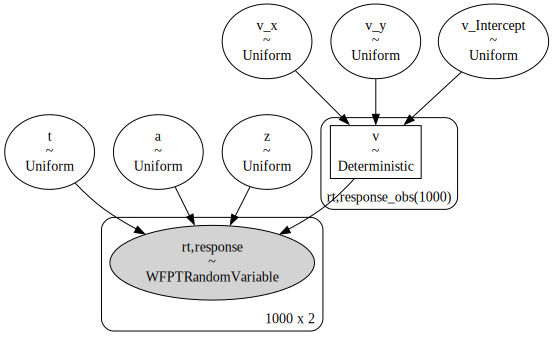

In [6]:
model_reg_v.graph()

In [6]:
trace_reg_v = model_reg_v.sample(cores=1, chains=2, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [z, t, a, v_Intercept, v_x, v_y]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 642 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: Us

array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>]],
      dtype=object)

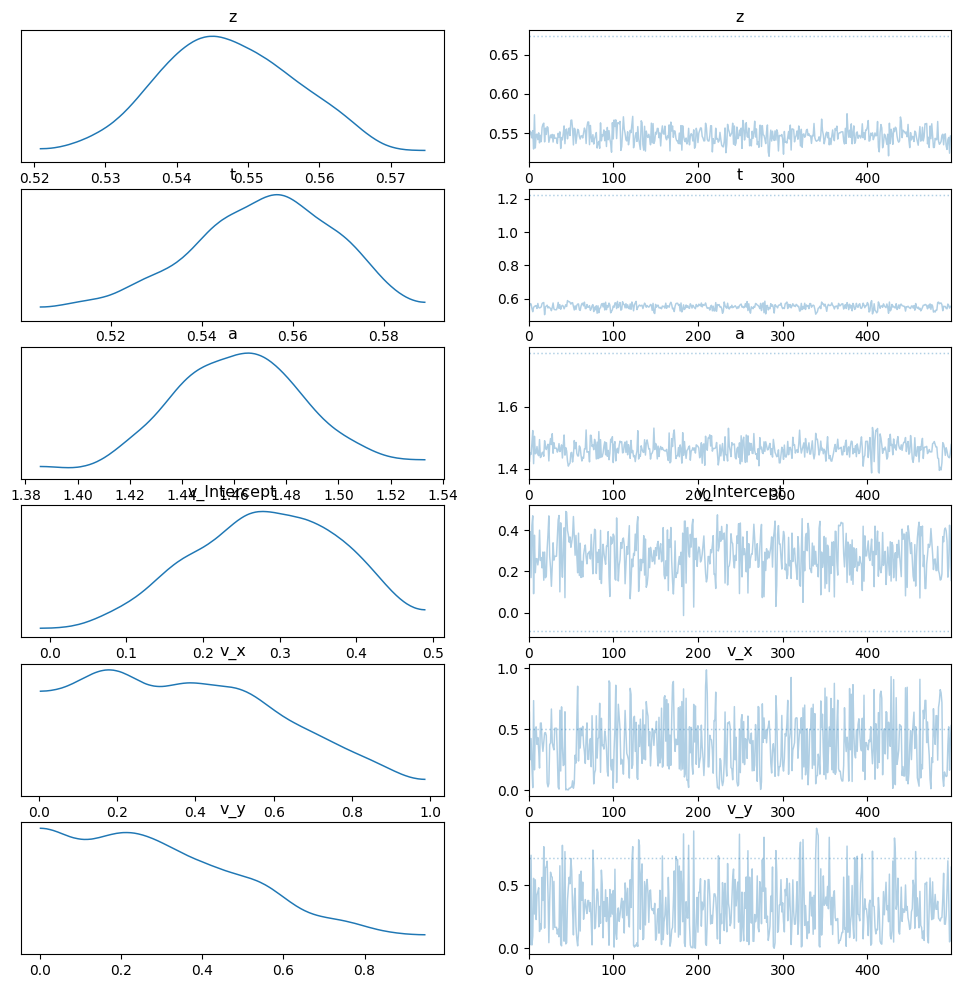

In [7]:
az.plot_trace(model_reg_v.traces)

In [8]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.610,0.063,0.536,0.673,0.044,0.037,3.0,96.0,2.23
t,0.888,0.336,0.532,1.223,0.235,0.199,3.0,141.0,2.23
a,1.619,0.157,1.433,1.774,0.110,0.092,3.0,249.0,2.23
v_Intercept,0.096,0.198,-0.090,0.397,0.132,0.109,3.0,2.0,2.23
v_x,0.442,0.176,0.004,0.686,0.040,0.029,66.0,69.0,2.23
v_y,0.521,0.249,0.026,0.714,0.141,0.115,4.0,230.0,2.23


In [9]:
new_data = pd.DataFrame({
    "x": np.random.uniform(0.2, 0.5, size=1000),
    "y": np.random.uniform(0.1, 0.4, size=1000),
})

In [10]:
posterior = model_reg_v.model.predict(model_reg_v.traces, data=new_data, inplace=False)

In [11]:
posterior

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/aomar7/Library/Caches/pypoetry/virtualenvs/hssm-t7Cza8gi-py3.11/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: Us

array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v_Intercept'}>,
        <Axes: title={'center': 'v_Intercept'}>],
       [<Axes: title={'center': 'v_x'}>, <Axes: title={'center': 'v_x'}>],
       [<Axes: title={'center': 'v_y'}>, <Axes: title={'center': 'v_y'}>],
       [<Axes: title={'center': 'rt,response_mean'}>,
        <Axes: title={'center': 'rt,response_mean'}>]], dtype=object)

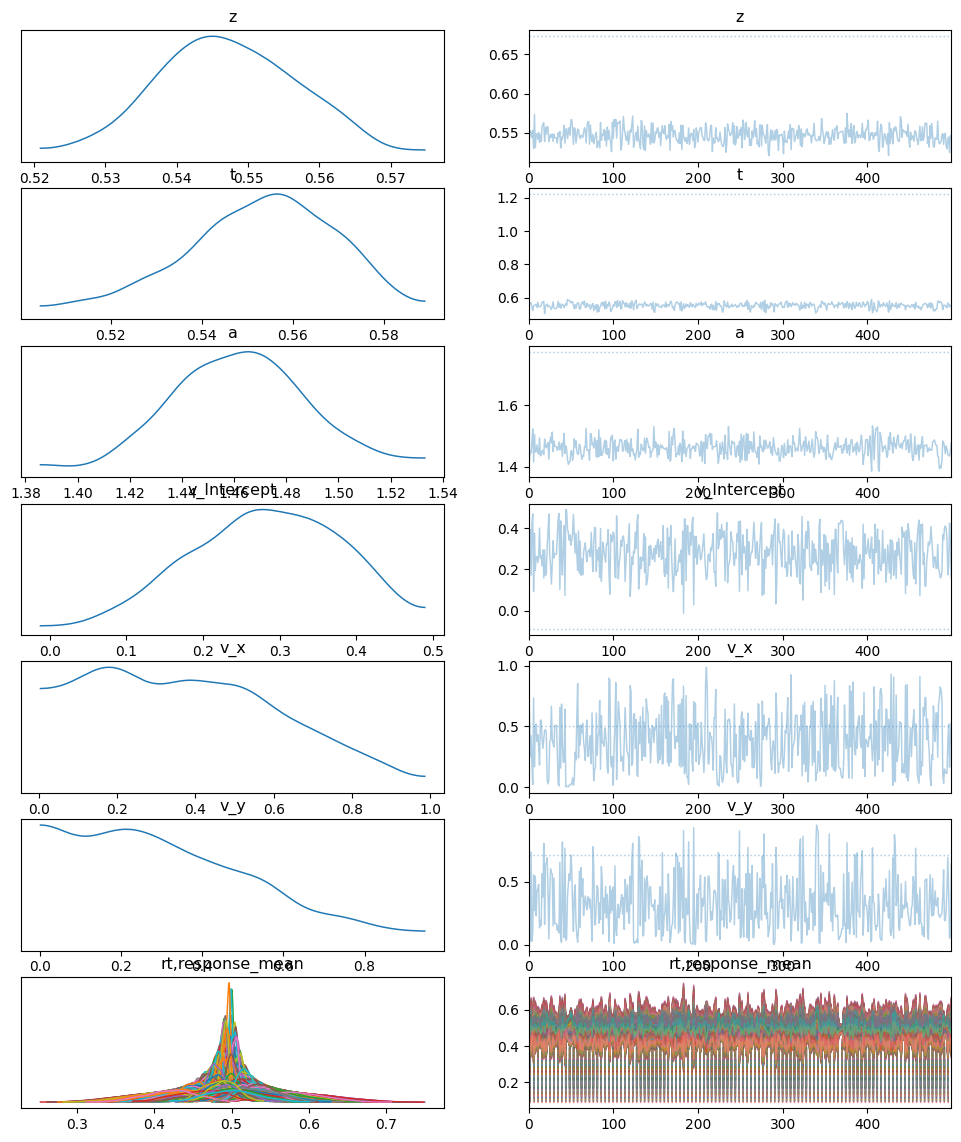

In [12]:
az.plot_trace(posterior)

In [13]:
posterior = model_reg_v.model.predict(model_reg_v.traces, data=new_data, inplace=False, kind="pps")

KeyError: 'a'

In [ ]:
model_reg_v.traces.posterior